In [1]:
#Import packages
import time
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models.vgg import vgg19
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # dataset
import matplotlib.pyplot as plt
import scipy
import numpy as np
import argparse
import glob
import imageio
import numpy
import natsort
import scipy
#from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import pprint
from scipy.ndimage import correlate
from scipy.ndimage.filters import gaussian_gradient_magnitude
import torchvision.datasets as dset
import torch.utils.data as data
from PIL import Image
import os
import os.path
from tkinter import *
import tkinter as tk
import tkinter.font as tkFont
from PIL import ImageTk, Image

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_properties(0).total_memory)

True
11811160064


In [3]:
#define the hyperparameters
image_length = 256
image_width  = 256
mr_channels  = 1
gray_channels = 1
pet_channels = 4    
rgb_channels = 3     
batch_size   = 2
EPOCH = 20
learning_rate = 0.002        

In [ ]:
#load the train mri data
filenames = os.listdir('/content/drive/My Drive/Training/MRI/')
dataset = os.path.join(os.getcwd(), '/content/drive/My Drive/Training/MRI/')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    train_mri[i,:,:] =(imageio.imread(data[i]))
    train_mri[i,:,:] =(train_mri[i,:,:] - np.min(train_mri[i,:,:])) / (np.max(train_mri[i,:,:]) - np.min(train_mri[i,:,:]))
    train_mri[i,:,:] = np.float32(train_mri[i,:,:])

In [ ]:
#expand dimension to add the channel
train_mri = np.expand_dims(train_mri,axis=1)

In [ ]:
#verify the shape matches the pytorch standard
train_mri.shape

In [ ]:
#convert the MRI training data to pytorch tensor
train_mri_tensor = torch.from_numpy(train_mri).float()
train_mri_tensor.shape

In [ ]:
#load the train pet data
filenames = os.listdir('/content/drive/My Drive/Training/PET/')
dataset = os.path.join(os.getcwd(), '/content/drive/My Drive/Training/PET/')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_other = np.zeros((len(data),image_width,image_length,pet_channels),dtype=float)
train_pet = np.zeros((len(data),image_width,image_length),dtype=float)
for i in range(len(data)):
    train_other[i,:,:,:] =(imageio.imread(data[i]))
    train_pet[i,:,:] = 0.2989 * train_other[i,:,:,0] + 0.5870 *  train_other[i,:,:,1]  + 0.1140 * train_other[i,:,:,2]
    train_pet[i,:,:] =(train_pet[i,:,:] - np.min(train_pet[i,:,:])) / (np.max(train_pet[i,:,:]) - np.min(train_pet[i,:,:]))

In [ ]:
#expand the dimension to add the channel
train_pet = np.expand_dims(train_pet,axis=1)

In [ ]:
#verify the shape matches the pytorch standard
train_pet.shape

In [ ]:
#convert the PET training data to pytorch tensor
train_pet_tensor = torch.from_numpy(train_pet).float()
train_pet_tensor.shape

In [4]:
#define the network
class FunFuseAn(nn.Module):
    def  __init__(self):
        super(FunFuseAn, self).__init__()
        #####mri lf layer 1#####
        self.mri_lf = nn.Sequential( #input shape (,1,256,256)
                         nn.Conv2d(in_channels=1, out_channels=16, kernel_size=9, stride=1, padding=4),
                         nn.BatchNorm2d(16),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,16,256,256)   
        #####mri hf layers#####
        self.mri_hf = nn.Sequential(  #input shape (,1,256,256)
                         nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(16),
                         nn.LeakyReLU(0.2,inplace=True),
                         nn.Conv2d(in_channels  = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
                         nn.BatchNorm2d(32),
                         nn.LeakyReLU(0.2,inplace=True),
                         nn.Conv2d(in_channels  = 32, out_channels = 64, kernel_size  = 3, stride = 1, padding = 1),
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,64,256,256)
        #####pet lf layer 1#####
        self.pet_lf = nn.Sequential( #input shape (,1,256,256)
                         nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=3),
                         nn.BatchNorm2d(16),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,16,256,256)   
        #####pet hf layers#####
        self.pet_hf = nn.Sequential(  #input shape (,1,256,256)
                         nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size  = 5, stride= 1, padding = 2),
                         nn.BatchNorm2d(16),
                         nn.LeakyReLU(0.2,inplace=True),
                         nn.Conv2d(in_channels  = 16, out_channels = 32, kernel_size = 5, stride = 1, padding = 2),
                         nn.BatchNorm2d(32),
                         nn.LeakyReLU(0.2,inplace=True),
                         nn.Conv2d(in_channels  = 32, out_channels = 64, kernel_size  = 3, stride = 1, padding = 1),
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,64,256,256)
        #####reconstruction layer 1#####
        self.recon1 = nn.Sequential(  #input shape (, 64, 256, 256)
                          nn.Conv2d(in_channels  = 64,  out_channels = 32, kernel_size  = 5, stride = 1, padding = 2),
                          nn.BatchNorm2d(32),
                          nn.LeakyReLU(0.2,inplace=True),
                          nn.Conv2d(in_channels  = 32, out_channels = 16, kernel_size  = 5, stride = 1, padding = 2),
                          nn.BatchNorm2d(16),
                          nn.LeakyReLU(0.2,inplace=True)) #output shape (,16, 256, 256)
        
        #####reconstruction layer 2#####
        self.recon2 = nn.Sequential(      #input shape (,16, 256, 256)
                            nn.Conv2d(in_channels  = 16, out_channels = 1, kernel_size  = 5, stride = 1, padding = 2))   #output shape (,1,256,256)

    def forward(self, x, y):
        #mri lf layer 1
        x1 = self.mri_lf(x)
        #mri hf layers
        x2 = self.mri_hf(x)
        #pet lf layer 1
        y1 = self.pet_lf(y)
        #pet hf layers
        y2 = self.pet_hf(y)
        #high frequency fusion layer
        fuse_hf = x2 + y2
        #reconstruction layer1
        recon_hf = self.recon1(fuse_hf)
        #low frequency fusion layer
        fuse_lf = (x1 + y1 + recon_hf)/3
        #reconstruction layer2
        recon3 = self.recon2(fuse_lf)
        #tanh layer
        fused = torch.tanh(recon3)      
        return fused
        #execute the network

cnn = FunFuseAn()
cnn = cnn.float()
print(cnn)

FunFuseAn(
  (mri_lf): Sequential(
    (0): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (mri_hf): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
  )
  (pet_lf): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), paddi

In [ ]:
#define the optimizers and loss functions 
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)   # optimize all cnn parameters
l2_loss   = nn.MSELoss() #MSEloss

In [ ]:
# perform the training
counter = 0
start_time = time.time()
lamda = 0.8
for epoch in range(EPOCH):
  #run batch images
  batch_idxs = 272 // batch_size
  for idx in range(0, batch_idxs):
    b_x = train_mri_tensor[idx*batch_size : (idx+1)*batch_size,:,:,:]
    b_y = train_pet_tensor[idx*batch_size : (idx+1)*batch_size,:,:,:]
    counter += 1
    output = cnn(b_x,b_y)               # cnn output
    ssim_loss_mri = 1 - ssim(output, b_x,data_range=1)
    ssim_loss_pet = 1 - ssim(output, b_y,data_range=1)
    ssim_total = ssim_loss_mri + ssim_loss_pet
    l2_total = l2_loss(output,b_x) + l2_loss(output,b_y)
    loss_total = lamda*ssim_total + (1-lamda)*l2_total 
    optimizer.zero_grad()           # clear gradients for this training step
    loss_total.backward()           # backpropagation, compute gradients
    optimizer.step()                # apply gradients
    if counter % 10 == 0:
      print("Epoch: [%2d],step: [%2d], mri_ssim_loss: [%.8f], pet_ssim_loss: [%.8f],  total_ssim_loss: [%.8f], total_l2_loss: [%.8f], total_loss: [%.8f]" 
            %(epoch, counter, ssim_loss_mri, ssim_loss_pet, ssim_total, l2_total, loss_total))

    if(epoch == EPOCH -1):
      #Save a checkpoint
      torch.save(cnn, '/content/drive/My Drive/Training/Checkpoint/checkpoint.pth') 

In [54]:
#load the test input MRI dataset
filenames = os.listdir('C:/Users/horan/Desktop/Suraka/Testing/MRI/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/Suraka/Testing/MRI/')
data = glob.glob(os.path.join(dataset, "*.png"))
data = natsort.natsorted(data,reverse=False)
test_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_mri[i,:,:] =(imageio.imread(data[i]))
    test_mri[i,:,:] =(test_mri[i,:,:] - np.min(test_mri[i,:,:])) / (np.max(test_mri[i,:,:]) - np.min(test_mri[i,:,:]))
    test_mri[i,:,:] = np.float32(test_mri[i,:,:])

In [55]:
#expand dimension to add the channel
test_mri = np.expand_dims(test_mri,axis=1)
#verify the shape matches the pytorch standard
test_mri.shape

(4, 1, 256, 256)

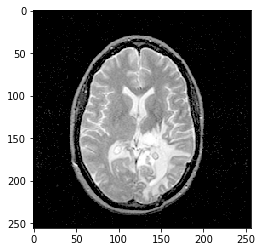

In [56]:
#verify the test mri image
test_mri = test_mri[2,:,:,:]
test_mri = np.expand_dims(test_mri,axis=0)
plt.imshow(test_mri[0,0,:,:],'gray')

In [57]:
np.max(test_mri)

1.0

In [58]:
#convert the MRI Testing data to pytorch tensor
test_mri_tensor = torch.from_numpy(test_mri).float()
print(test_mri_tensor.shape)
test_mri_tensor.requires_grad =True

torch.Size([1, 1, 256, 256])


In [59]:
#load the test input PET dataset
filenames = os.listdir('C:/Users/horan/Desktop/Suraka/Testing/PET/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/Suraka/Testing/PET/')
data = glob.glob(os.path.join(dataset, "*.png"))
data = natsort.natsorted(data,reverse=False)
test_pet = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_pet[i,:,:] =(imageio.imread(data[i]))
    test_pet[i,:,:] =(test_pet[i,:,:] - np.min(test_pet[i,:,:])) / (np.max(test_pet[i,:,:]) - np.min(test_pet[i,:,:]))
    test_pet[i,:,:] = np.float32(test_pet[i,:,:])

In [60]:
#expand dimension to add the channel
test_pet = np.expand_dims(test_pet,axis=1)
#verify the shape matches the pytorch standard
test_pet.shape 

(4, 1, 256, 256)

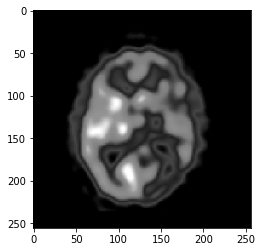

In [61]:
#verify the test pet image
test_pet = test_pet[2,:,:,:]
test_pet = np.expand_dims(test_pet,axis=0)
plt.imshow(test_pet[0,0,:,:],'gray')

In [62]:
#convert the MRI Testing data to pytorch tensor
test_pet_tensor = torch.from_numpy(test_pet).float()
print(test_pet_tensor.shape)
test_pet_tensor.requires_grad =True

torch.Size([1, 1, 256, 256])


In [65]:
#load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn =torch.load('C:/Users/horan/Desktop/Suraka/gui/.ipynb_checkpoints/checkpoint.pth')
cnn.eval()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\torch\serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\torch\serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\torch\serialization.py:434: SourceChangeWarning: source code of class 't

FunFuseAn(
  (mri_lf): Sequential(
    (0): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (mri_hf): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
  )
  (pet_lf): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), paddi

In [66]:
#predicted the fused image
fused = cnn(test_mri_tensor, test_pet_tensor)
fused_numpy = fused.data.cpu().numpy()

In [67]:
fused.shape

torch.Size([1, 1, 256, 256])

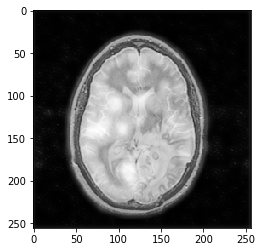

In [68]:
#verify the output image
plt.imshow(fused_numpy[0,0,:,:],'gray')

In [69]:
#define the window
root = Tk()  
root.title('Visualisation of fusion networks')
root.configure(background='white')
root.mainloop()  #keep the GUI open

In [70]:
#calculate the jacobian matrix
time1 = time.time()
count = 0 
for i in range(1):
    for j in range(1):
        #fused wrt mri
        jacobian_fuse_mri = torch.autograd.grad(fused[0,0,50,50], test_mri_tensor, retain_graph=True, create_graph=True)[0]
        time2 = time.time()
        jacob_val = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())
        x = np.asarray(np.where(np.any(jacob_val, axis = 0)))
        y = np.asarray(np.where(np.any(jacob_val, axis = 1)))
        minx, maxx, miny, maxy = np.min(x), np.max(x), np.min(y), np.max(y)  #return min and max coordinates
        zoom_im = jacob_val[miny:maxy,minx:maxx]   
        f = plt.figure()
        f.add_subplot(1,2,1)
        plt.imshow(jacob_val,cmap='hot')    
        f.add_subplot(1,2,2)
        plt.imshow(zoom_im, cmap='hot')
        plt.colorbar()
        #plt.savefig('/content/drive/My Drive/Fused_MRI/im_' + str(i) + '_' + str(j) + '.png',dpi=100)
        plt.close()
        del jacobian_fuse_mri, jacob_val, zoom_im, f         
        #fused wrt pet
        jacobian_fuse_pet = torch.autograd.grad(fused[0,0,50,50], test_pet_tensor, retain_graph=True, create_graph=True)[0]
        jacob_val = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
        x = np.asarray(np.where(np.any(jacob_val, axis = 0)))
        y = np.asarray(np.where(np.any(jacob_val, axis = 1)))
        minx, maxx, miny, maxy = np.min(x), np.max(x), np.min(y), np.max(y)  #return min and max coordinates
        zoom_im = jacob_val[miny:maxy,minx:maxx]  
        f = plt.figure()
        f.add_subplot(1,2,1)
        plt.imshow(jacob_val,cmap='hot')
        f.add_subplot(1,2,2)
        plt.imshow(zoom_im, cmap='hot')
        plt.colorbar()
        #plt.savefig('/content/drive/My Drive/Fused_PET/im_' + str(i) + '_' + str(j) + '.png',dpi=100)        
        plt.close()
        del jacobian_fuse_pet, jacob_val, zoom_im, f    
        count += 1
        if count % 100 == 0:   
            print (count)

In [71]:
print(time2-time1)

0.6552469730377197
